<a href="https://colab.research.google.com/github/Ghzraza/Ethological-Behavioral-Analysis/blob/main/Multi_animal_tracking_for_Labonte_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Behavioral metrics for each mouse:

   Mouse  Total_Distance  Time_in_Center  Time_Near_Object
0      1      747.985466               2                 2
1      2      787.560673               3               120
2      3      769.246122               0               121


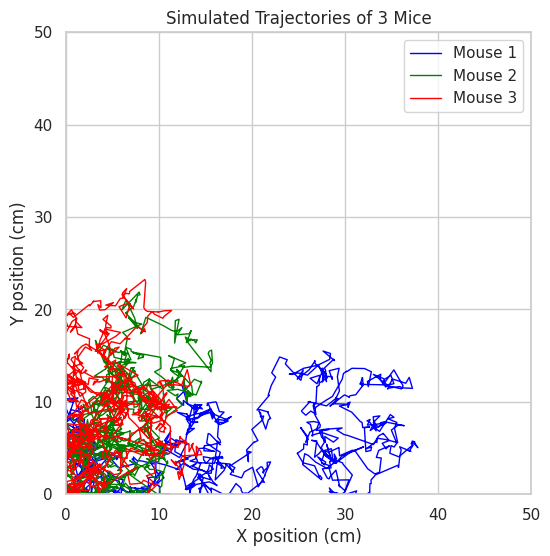

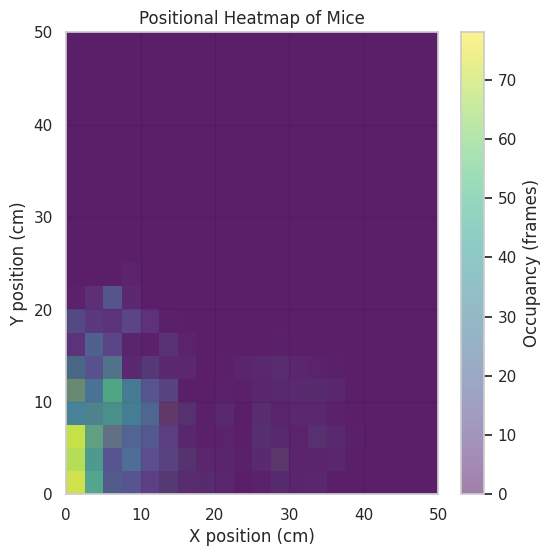


AI-based behavior prediction results:

              precision    recall  f1-score   support

           0       0.70      0.87      0.77       423
           1       0.23      0.09      0.13       177

    accuracy                           0.64       600
   macro avg       0.46      0.48      0.45       600
weighted avg       0.56      0.64      0.58       600



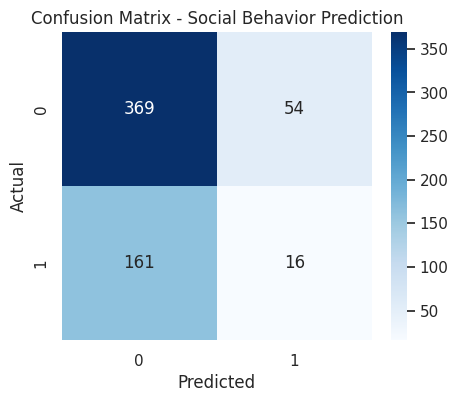

All mouse positional data saved.


In [2]:
# -----------------------------
# Multi-Animal Behavioral Tracking Simulation
# For Labonté Lab
# Author: Ghazal Raza
# -----------------------------

# Step 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid", context="notebook")

# Step 2: Simulate 3 mice moving in a 50x50 cm arena over 1000 frames
np.random.seed(42)
n_timepoints = 1000
arena_size = 50
n_mice = 3

# Initialize position arrays
x = np.zeros((n_mice, n_timepoints))
y = np.zeros((n_mice, n_timepoints))

# Random walk simulation for each mouse
for m in range(n_mice):
    for t in range(1, n_timepoints):
        step_size = np.random.normal(0, 1)
        angle = np.random.uniform(0, 2*np.pi)
        x[m, t] = np.clip(x[m, t-1] + step_size*np.cos(angle), 0, arena_size)
        y[m, t] = np.clip(y[m, t-1] + step_size*np.sin(angle), 0, arena_size)

# Step 3: Define zones (center and object zones)
center_min = arena_size/2 - 10
center_max = arena_size/2 + 10
object_zone = {'x_min': 5, 'x_max': 10, 'y_min': 5, 'y_max': 10}

# Step 4: Calculate metrics for each mouse
metrics = []

for m in range(n_mice):
    dx = np.diff(x[m])
    dy = np.diff(y[m])
    distance = np.sqrt(dx**2 + dy**2)
    speed = distance
    total_distance = np.sum(distance)

    # Time in center
    in_center = ((x[m] > center_min) & (x[m] < center_max) & (y[m] > center_min) & (y[m] < center_max))
    time_in_center = np.sum(in_center)

    # Time near object
    in_object = ((x[m] > object_zone['x_min']) & (x[m] < object_zone['x_max']) &
                 (y[m] > object_zone['y_min']) & (y[m] < object_zone['y_max']))
    time_near_object = np.sum(in_object)

    metrics.append({
        'Mouse': m+1,
        'Total_Distance': total_distance,
        'Time_in_Center': time_in_center,
        'Time_Near_Object': time_near_object
    })

metrics_df = pd.DataFrame(metrics)
print("Behavioral metrics for each mouse:\n")
print(metrics_df)

# Step 5: Visualize trajectories
plt.figure(figsize=(6,6))
colors = ['blue', 'green', 'red']
for m in range(n_mice):
    plt.plot(x[m], y[m], lw=1, color=colors[m], label=f'Mouse {m+1}')
plt.xlim(0, arena_size)
plt.ylim(0, arena_size)
plt.xlabel("X position (cm)")
plt.ylabel("Y position (cm)")
plt.title("Simulated Trajectories of 3 Mice")
plt.legend()
plt.show()

# Step 6: Positional heatmaps
plt.figure(figsize=(6,6))
for m in range(n_mice):
    plt.hist2d(x[m], y[m], bins=20, range=[[0, arena_size],[0, arena_size]], cmap='viridis', alpha=0.5)
plt.colorbar(label='Occupancy (frames)')
plt.xlabel("X position (cm)")
plt.ylabel("Y position (cm)")
plt.title("Positional Heatmap of Mice")
plt.show()

# Step 7: Simulate simple behavior labels for AI prediction
labels = []
features = []

for m in range(n_mice):
    for t in range(n_timepoints):
        # Social if within 5 cm of any other mouse
        other_mice = [i for i in range(n_mice) if i != m]
        social = any(np.sqrt((x[m,t]-x[o,t])**2 + (y[m,t]-y[o,t])**2) < 5 for o in other_mice)
        labels.append(int(social))
        # Features: X, Y, speed at this frame
        if t==0:
            spd = 0
        else:
            spd = np.sqrt((x[m,t]-x[m,t-1])**2 + (y[m,t]-y[m,t-1])**2)
        features.append([x[m,t], y[m,t], spd])

X = np.array(features)
y_labels = np.array(labels)

# Step 8: Train/test split and AI model
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nAI-based behavior prediction results:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Social Behavior Prediction")
plt.show()

# Step 9: Save data
for m in range(n_mice):
    df = pd.DataFrame({'Time': np.arange(n_timepoints),
                       'X': x[m],
                       'Y': y[m]})
    # Corrected speed calculation
    df['Speed'] = np.concatenate(([0], np.sqrt(np.diff(df['X'])**2 + np.diff(df['Y'])**2)))
    df.to_csv(f"mouse_{m+1}_tracking.csv", index=False)
print("All mouse positional data saved.")
